# DATA LOADING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import itertools
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.optimize import minimize
import time

warnings.simplefilter('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
print("📊 Loading data...")
train = pd.read_csv("D:/Perkuliahan/Data Science and Machine Learning/File Dataset/Predict Calorie Expenditure/train.csv")
test = pd.read_csv("D:/Perkuliahan/Data Science and Machine Learning/File Dataset/Predict Calorie Expenditure/test.csv")
submission = pd.read_csv("D:/Perkuliahan/Data Science and Machine Learning/File Dataset/Predict Calorie Expenditure/sample_submission.csv")

print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

📊 Loading data...
Train data shape: (750000, 9)
Test data shape: (250000, 8)


# EXPLORATORY DATA ANALYSIS (EDA)


📈 EXPLORATORY DATA ANALYSIS

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
None

Deskripsi Statistik:
                  id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      41.420404     174.697685      75.145668   
std    216506.495284      15.175049      12.824496      13.982704   
min         0.0000

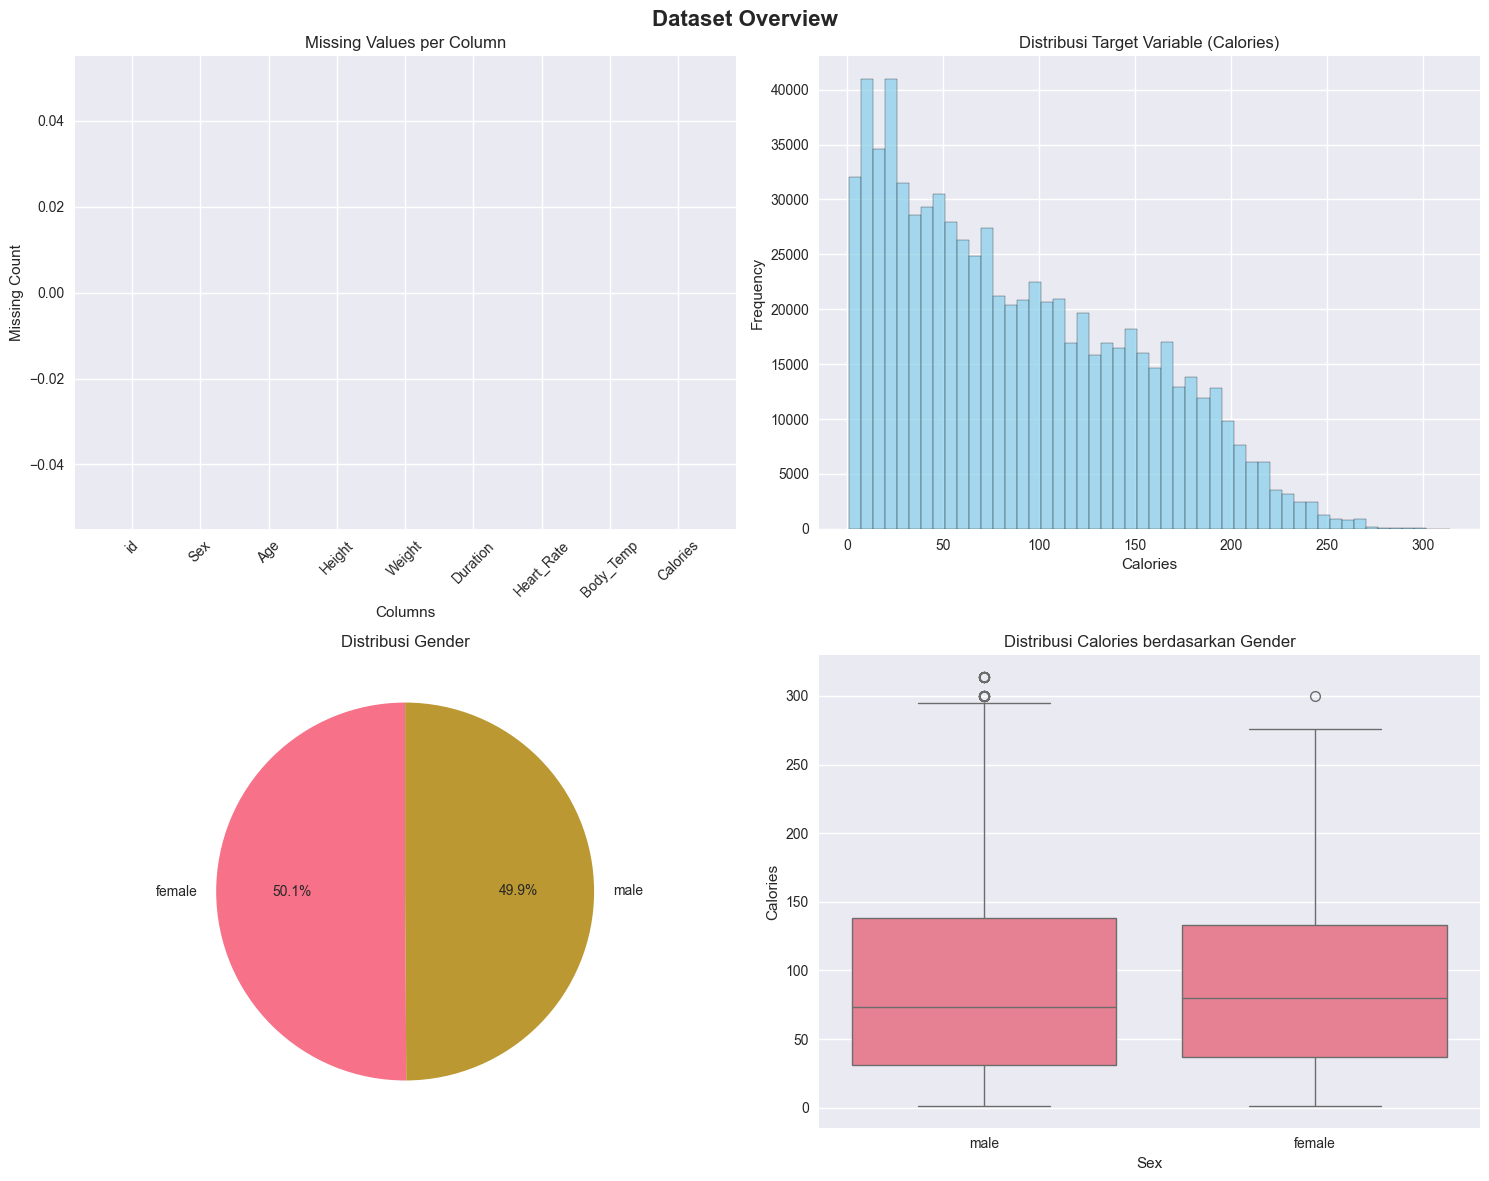

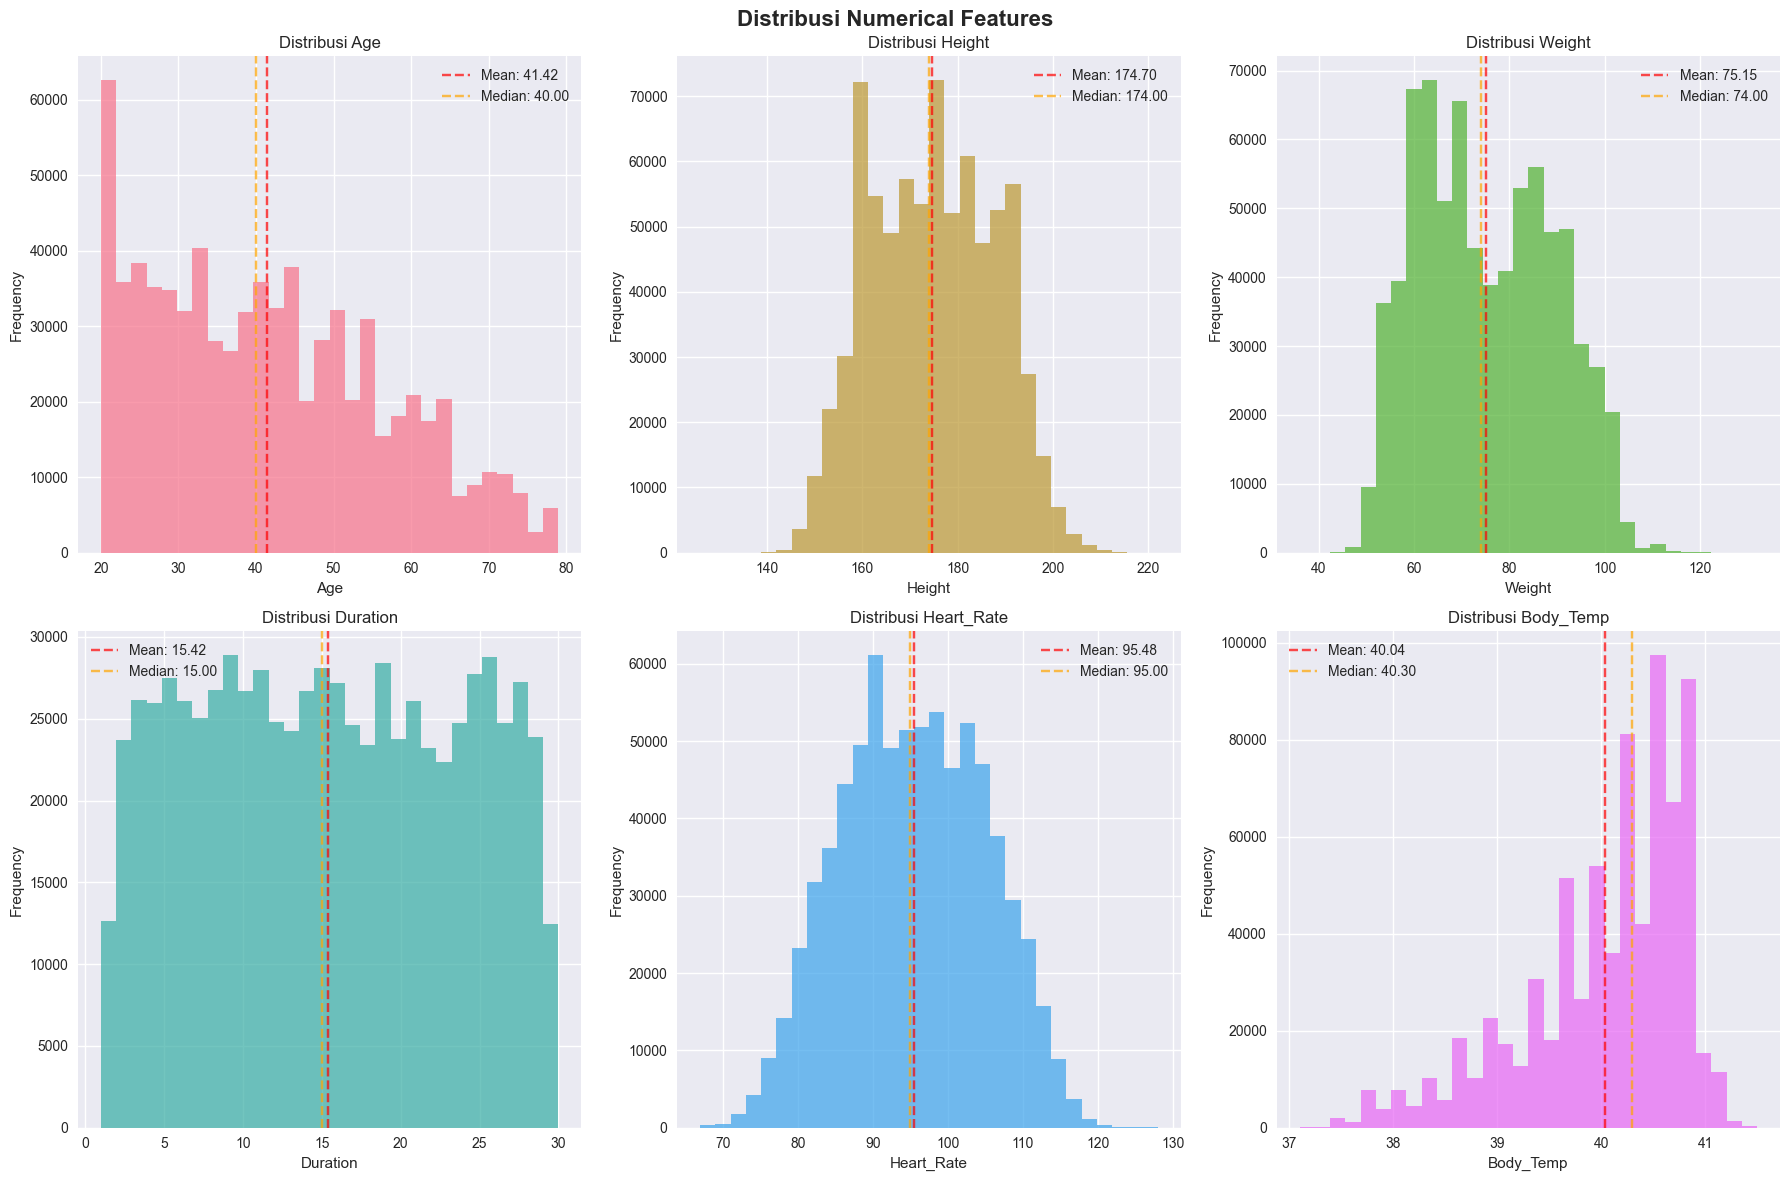

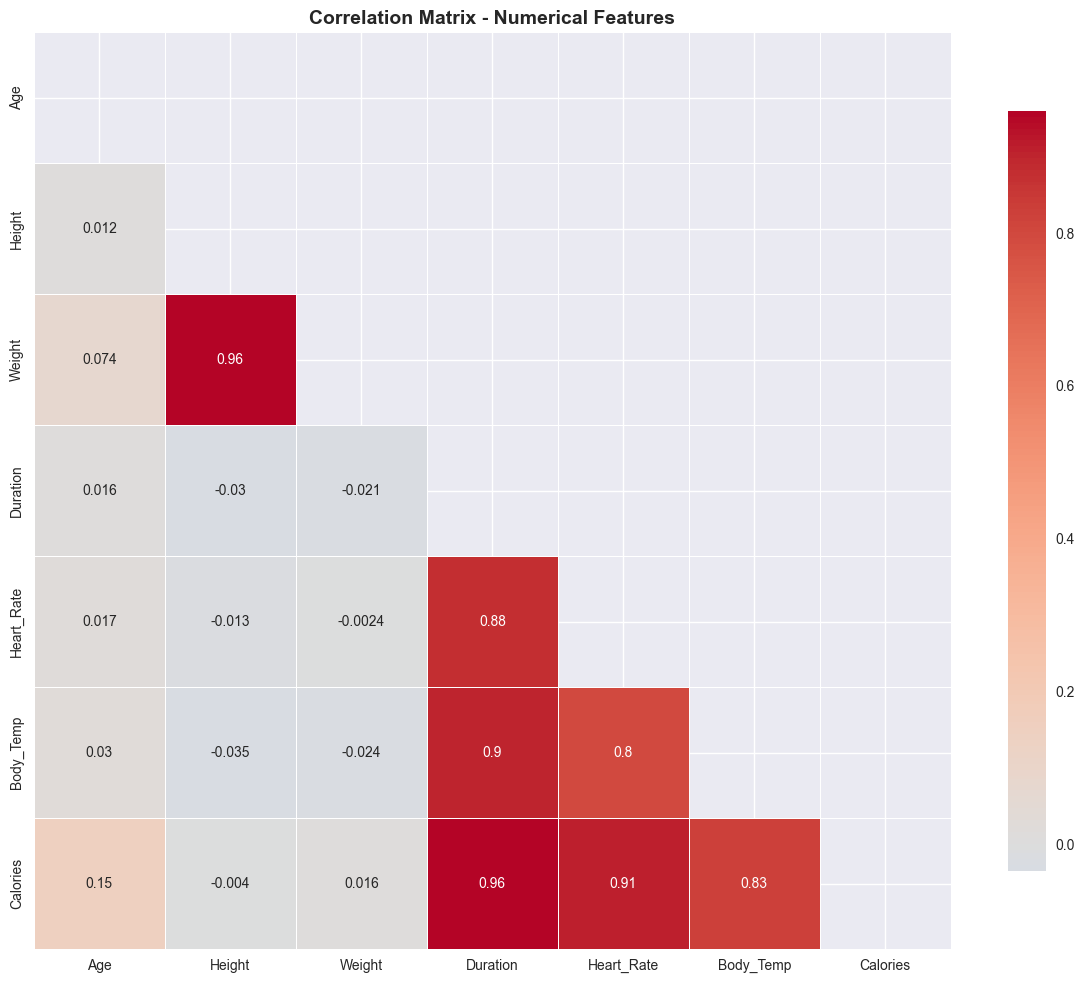

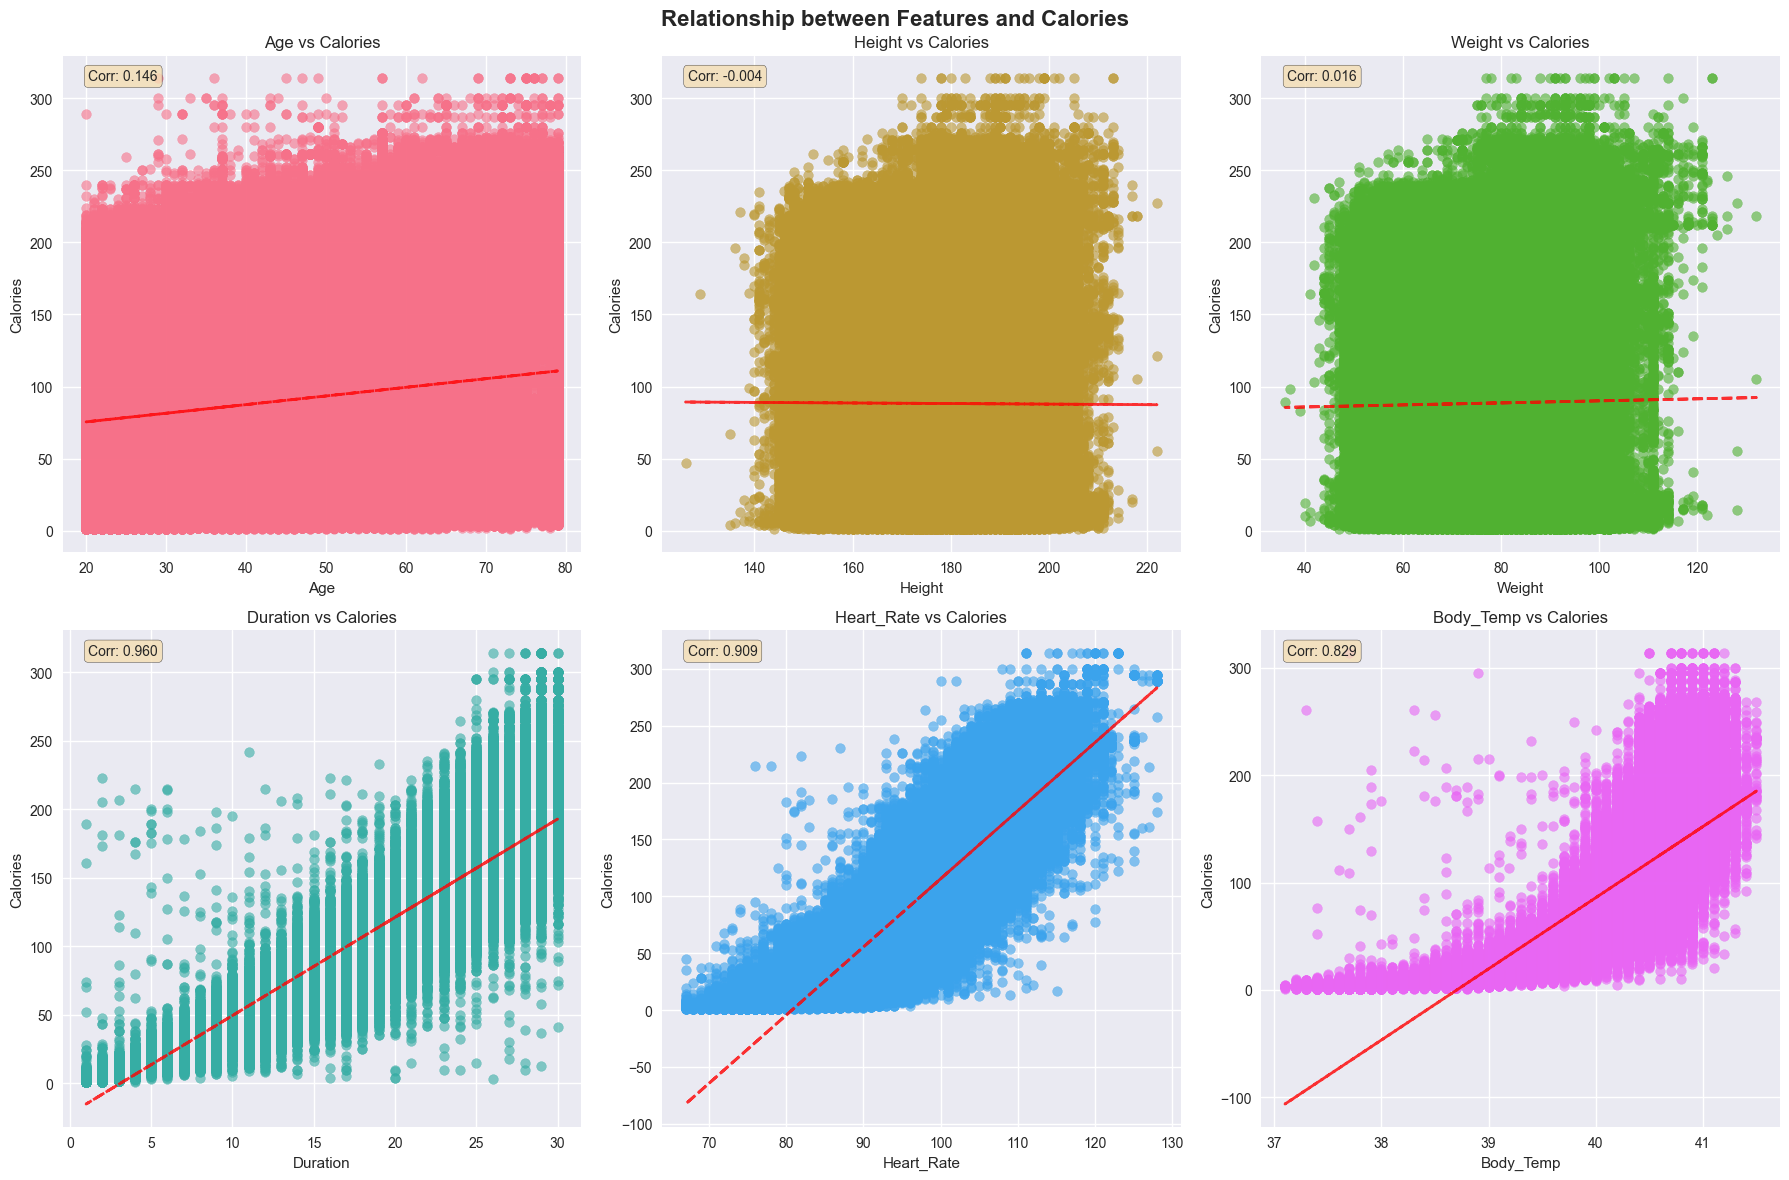

In [2]:
# Basic info
print("\n" + "="*50)
print("📈 EXPLORATORY DATA ANALYSIS")
print("="*50)

print("\nInfo Dataset:")
print(train.info())
print("\nDeskripsi Statistik:")
print(train.describe())

# Visualisasi 1: Dataset Overview
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Dataset Overview', fontsize=16, fontweight='bold')

# Missing values
missing_data = train.isnull().sum()
axes[0,0].bar(missing_data.index, missing_data.values)
axes[0,0].set_title('Missing Values per Column')
axes[0,0].set_xlabel('Columns')
axes[0,0].set_ylabel('Missing Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Target distribution
axes[0,1].hist(train['Calories'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('Distribusi Target Variable (Calories)')
axes[0,1].set_xlabel('Calories')
axes[0,1].set_ylabel('Frequency')

# Gender distribution
gender_counts = train['Sex'].value_counts()
axes[1,0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Distribusi Gender')

# Calories by Gender
sns.boxplot(data=train, x='Sex', y='Calories', ax=axes[1,1])
axes[1,1].set_title('Distribusi Calories berdasarkan Gender')

plt.tight_layout()
plt.show()

# Visualisasi 2: Numerical Features Analysis
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
fig.suptitle('Distribusi Numerical Features', fontsize=16, fontweight='bold')

for i, feature in enumerate(numerical_features):
    axes[i].hist(train[feature], bins=30, alpha=0.7, color=sns.color_palette("husl", len(numerical_features))[i])
    axes[i].set_title(f'Distribusi {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    
    # Add statistics
    mean_val = train[feature].mean()
    median_val = train[feature].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Visualisasi 3: Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = train[numerical_features + ['Calories']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualisasi 4: Feature vs Target Scatter Plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
fig.suptitle('Relationship between Features and Calories', fontsize=16, fontweight='bold')

for i, feature in enumerate(numerical_features):
    axes[i].scatter(train[feature], train['Calories'], alpha=0.6, 
                   color=sns.color_palette("husl", len(numerical_features))[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Calories')
    axes[i].set_title(f'{feature} vs Calories')
    
    # Add trend line
    z = np.polyfit(train[feature], train['Calories'], 1)
    p = np.poly1d(z)
    axes[i].plot(train[feature], p(train[feature]), "r--", alpha=0.8, linewidth=2)
    
    # Add correlation coefficient
    corr = train[feature].corr(train['Calories'])
    axes[i].text(0.05, 0.95, f'Corr: {corr:.3f}', transform=axes[i].transAxes, 
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# FEATURE ENGINEERING AND DATA SPLITTING


🔧 FEATURE ENGINEERING
Applying feature engineering...
✅ Added 15 cross terms
✅ Added 15 cross terms
✅ Added 75 interaction features
✅ Added 75 interaction features
✅ Added 5 statistical features
✅ Added 5 statistical features
Features sebelum: 9
Features sesudah: 104
Total features ditambahkan: 95

Adding polynomial features...
Final features count: 125
Total features untuk modeling: 123


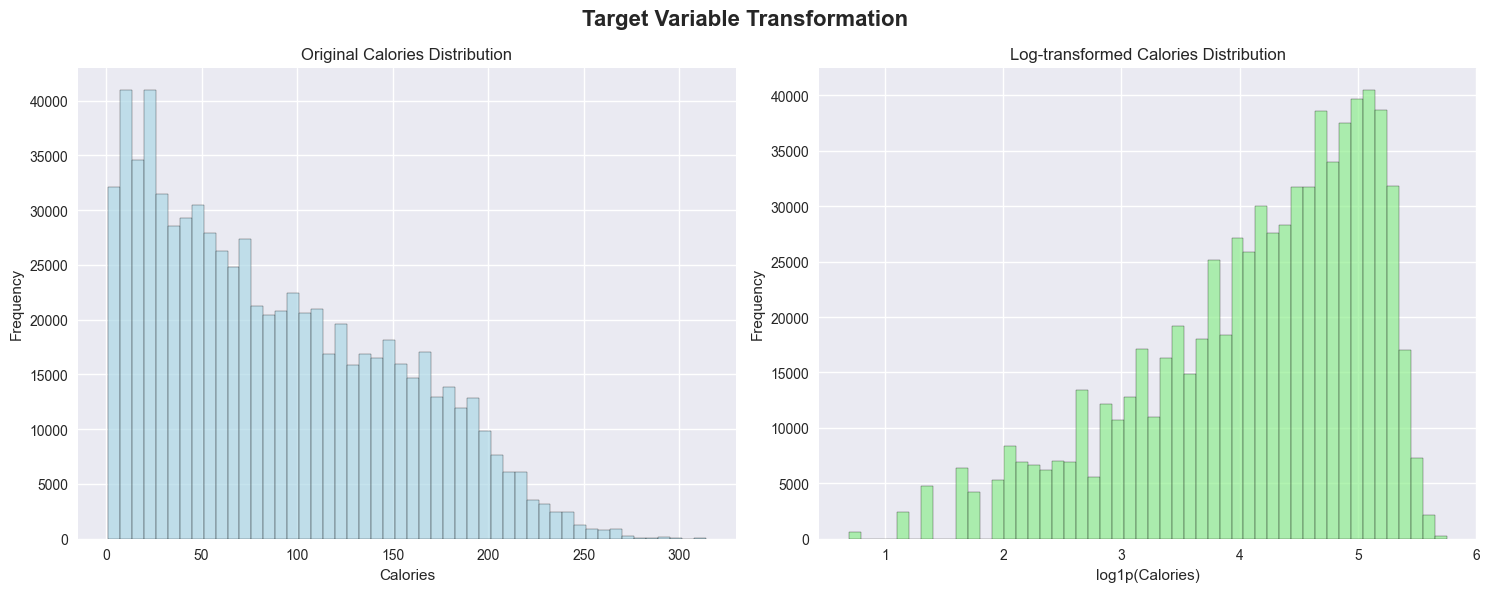

In [3]:
print("\n" + "="*50)
print("🔧 FEATURE ENGINEERING")
print("="*50)

def add_feature_cross_terms(df, features):
    """Menambahkan feature cross terms (perkalian antar feature)"""
    df = df.copy()
    df = df.loc[:, ~df.columns.duplicated()]  
    cross_features = []
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            f1 = features[i]
            f2 = features[j]
            new_feature = f"{f1}_x_{f2}"
            df[new_feature] = df[f1] * df[f2]
            cross_features.append(new_feature)
    print(f"✅ Added {len(cross_features)} cross terms")
    return df

def add_interaction_features(df, features):
    """Menambahkan interaction features (operasi matematika antar feature)"""
    df_new = df.copy()
    interaction_features = []
    for f1, f2 in itertools.combinations(features, 2):
        # Addition
        new_feature = f"{f1}_plus_{f2}"
        df_new[new_feature] = df_new[f1] + df_new[f2]
        interaction_features.append(new_feature)
        
        # Subtraction
        new_feature = f"{f1}_minus_{f2}"
        df_new[new_feature] = df_new[f1] - df_new[f2]
        interaction_features.append(new_feature)
        
        new_feature = f"{f2}_minus_{f1}"
        df_new[new_feature] = df_new[f2] - df_new[f1]
        interaction_features.append(new_feature)
        
        # Division
        new_feature = f"{f1}_div_{f2}"
        df_new[new_feature] = df_new[f1] / (df_new[f2] + 1e-5)
        interaction_features.append(new_feature)
        
        new_feature = f"{f2}_div_{f1}"
        df_new[new_feature] = df_new[f2] / (df_new[f1] + 1e-5)
        interaction_features.append(new_feature)
    
    print(f"✅ Added {len(interaction_features)} interaction features")
    return df_new

def add_statistical_features(df, features):
    """Menambahkan statistical features dari numerical features"""
    df_new = df.copy()
    df_new["row_mean"] = df[features].mean(axis=1)
    df_new["row_std"] = df[features].std(axis=1)
    df_new["row_max"] = df[features].max(axis=1)
    df_new["row_min"] = df[features].min(axis=1)
    df_new["row_median"] = df[features].median(axis=1)
    print("✅ Added 5 statistical features")
    return df_new

# Apply feature engineering
print("Applying feature engineering...")
train_original_shape = train.shape[1]

train = add_feature_cross_terms(train, numerical_features)
test = add_feature_cross_terms(test, numerical_features)

train = add_interaction_features(train, numerical_features)
test = add_interaction_features(test, numerical_features)

train = add_statistical_features(train, numerical_features)
test = add_statistical_features(test, numerical_features)

print(f"Features sebelum: {train_original_shape}")
print(f"Features sesudah: {train.shape[1]}")
print(f"Total features ditambahkan: {train.shape[1] - train_original_shape}")

# Encode categorical variable
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

train['Sex'] = train['Sex'].astype('category')
test['Sex'] = test['Sex'].astype('category')

# Add polynomial features
print("\nAdding polynomial features...")
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_train = poly.fit_transform(train[numerical_features])
poly_test = poly.transform(test[numerical_features])
poly_feature_names = poly.get_feature_names_out(numerical_features)

poly_train_df = pd.DataFrame(poly_train, columns=poly_feature_names)
poly_test_df = pd.DataFrame(poly_test, columns=poly_feature_names)

train = pd.concat([train.reset_index(drop=True), poly_train_df], axis=1)
test = pd.concat([test.reset_index(drop=True), poly_test_df], axis=1)

print(f"Final features count: {train.shape[1]}")

# Prepare data for modeling
X = train.drop(columns=['id', 'Calories'])
y = np.log1p(train['Calories'])  # Log transformation
X_test = test.drop(columns=['id'])

FEATURES = X.columns.tolist()
print(f"Total features untuk modeling: {len(FEATURES)}")

# Visualisasi 5: Target Distribution Before and After Log Transform
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Target Variable Transformation', fontsize=16, fontweight='bold')

axes[0].hist(train['Calories'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0].set_title('Original Calories Distribution')
axes[0].set_xlabel('Calories')
axes[0].set_ylabel('Frequency')

axes[1].hist(y, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Log-transformed Calories Distribution')
axes[1].set_xlabel('log1p(Calories)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



# MODEL TRAINING

In [4]:
print("\n" + "="*50)
print("🤖 MODEL TRAINING")
print("="*50)

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

models = {
    'CatBoost': CatBoostRegressor(verbose=100, random_seed=42, cat_features=['Sex'], early_stopping_rounds=100),
    'XGBoost': XGBRegressor(max_depth=10, colsample_bytree=0.7, subsample=0.9, n_estimators=2000, learning_rate=0.02,
                            gamma=0.01, max_delta_step=2, early_stopping_rounds=100, eval_metric='rmse',
                            enable_categorical=True, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=2000, learning_rate=0.02, max_depth=10, colsample_bytree=0.7,
                              subsample=0.9, random_state=42, verbose=-1)
}

results = {name: {'oof': np.zeros(len(train)), 'pred': np.zeros(len(test)), 'rmsle': [], 'time': []} 
           for name in models}

# Training loop
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    for i, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
        print(f"\nFold {i+1}")
        x_train, y_train = X.iloc[train_idx], y[train_idx]
        x_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
        
        x_train = x_train.loc[:, ~x_train.columns.duplicated()]
        x_valid = x_valid.loc[:, ~x_valid.columns.duplicated()]
        x_test = X_test.loc[:, ~X_test.columns.duplicated()].copy()

        start = time.time()
        
        if name == 'XGBoost':
            model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=100)
        elif name == 'CatBoost':
            model.fit(x_train, y_train, eval_set=(x_valid, y_valid))
        else:
            model.fit(x_train, y_train)

        training_time = time.time() - start
        
        oof_pred = model.predict(x_valid)
        test_pred = model.predict(x_test)
        
        results[name]['oof'][valid_idx] = oof_pred
        results[name]['pred'] += test_pred / FOLDS
        
        rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_valid), np.expm1(oof_pred)))
        results[name]['rmsle'].append(rmsle)
        results[name]['time'].append(training_time)
        
        print(f"Fold {i+1} RMSLE: {rmsle:.4f}")
        print(f"Training time: {training_time:.1f} sec")


🤖 MODEL TRAINING

=== Training CatBoost ===

Fold 1
Learning rate set to 0.14053
0:	learn: 0.8364851	test: 0.8356619	best: 0.8356619 (0)	total: 269ms	remaining: 4m 28s
100:	learn: 0.0631319	test: 0.0638931	best: 0.0638931 (100)	total: 12.2s	remaining: 1m 48s
200:	learn: 0.0604752	test: 0.0620627	best: 0.0620627 (200)	total: 23.3s	remaining: 1m 32s
300:	learn: 0.0590925	test: 0.0612550	best: 0.0612550 (300)	total: 34.6s	remaining: 1m 20s
400:	learn: 0.0582505	test: 0.0608786	best: 0.0608786 (400)	total: 45.9s	remaining: 1m 8s
500:	learn: 0.0576006	test: 0.0606443	best: 0.0606397 (497)	total: 57.1s	remaining: 56.9s
600:	learn: 0.0570770	test: 0.0605160	best: 0.0605160 (600)	total: 1m 8s	remaining: 45.3s
700:	learn: 0.0566363	test: 0.0604217	best: 0.0604215 (694)	total: 1m 19s	remaining: 33.8s
800:	learn: 0.0562358	test: 0.0603571	best: 0.0603571 (800)	total: 1m 31s	remaining: 22.7s
900:	learn: 0.0558598	test: 0.0602745	best: 0.0602745 (900)	total: 1m 42s	remaining: 11.3s
999:	learn: 0.0

# MODEL EVALUATION & VISUALIZATION


📊 MODEL EVALUATION
CatBoost - Mean RMSLE: 0.0599 ± 0.0003 | Avg Time: 118.2s
XGBoost - Mean RMSLE: 0.0598 ± 0.0005 | Avg Time: 119.4s
LightGBM - Mean RMSLE: 0.0600 ± 0.0004 | Avg Time: 108.9s


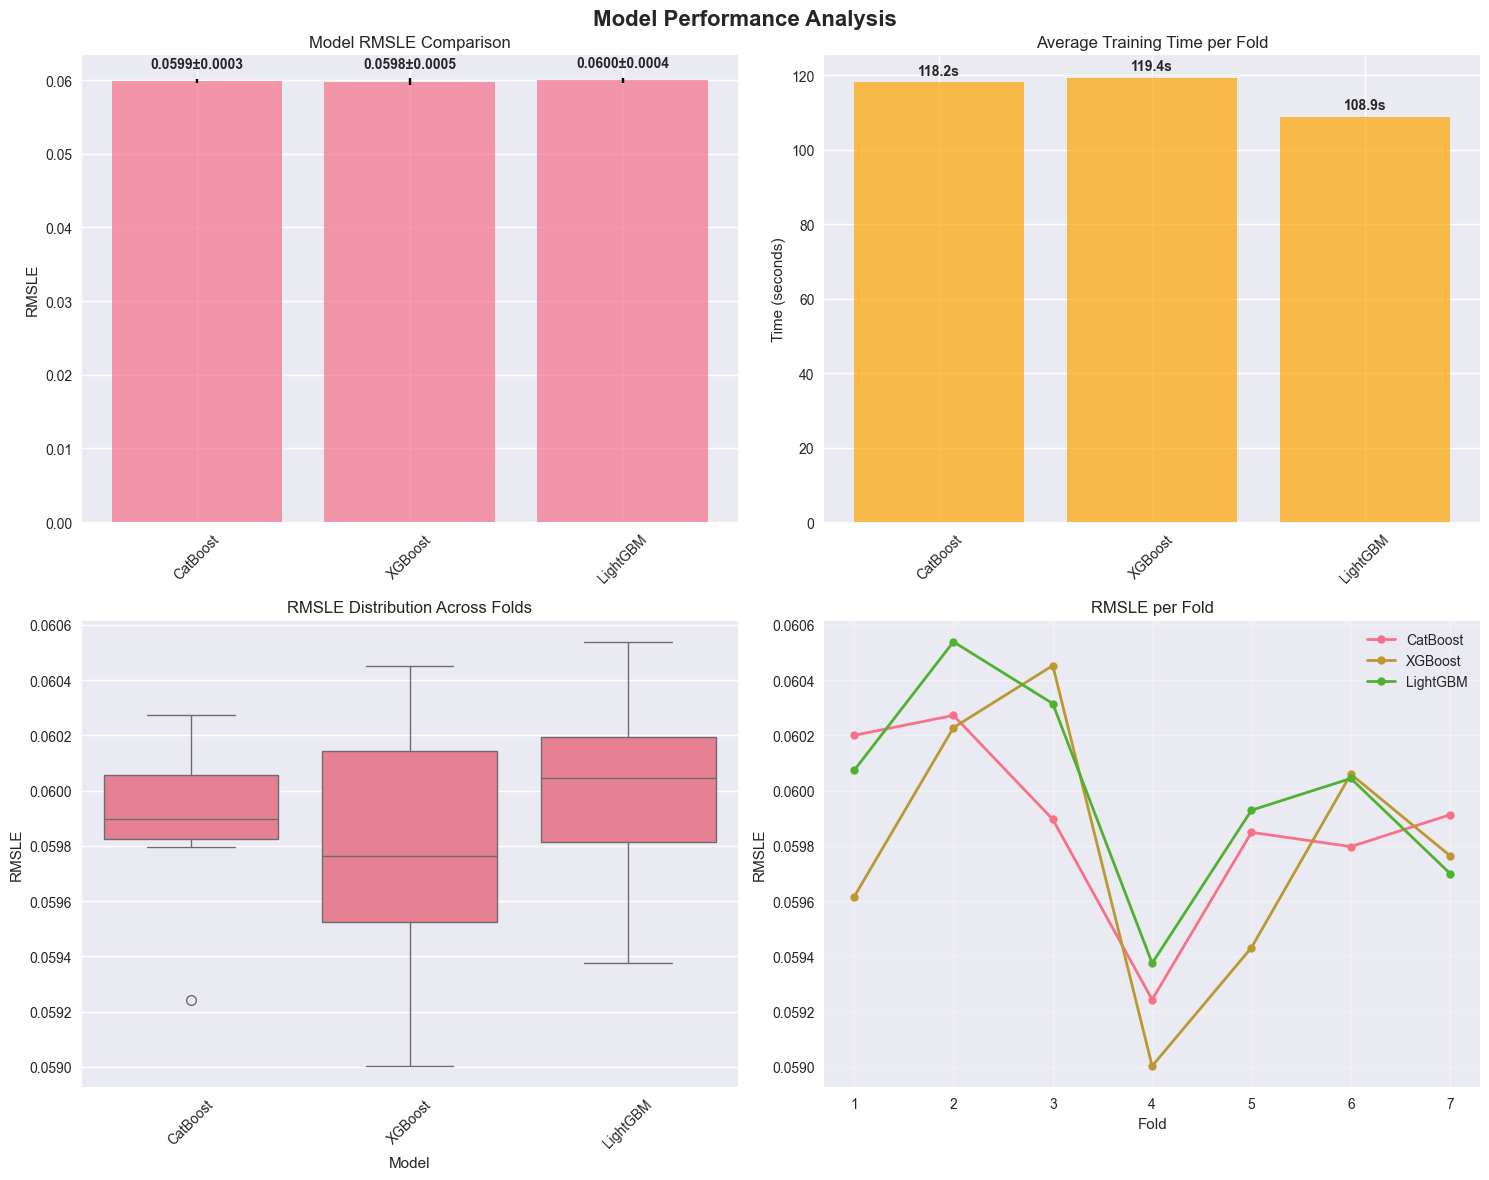

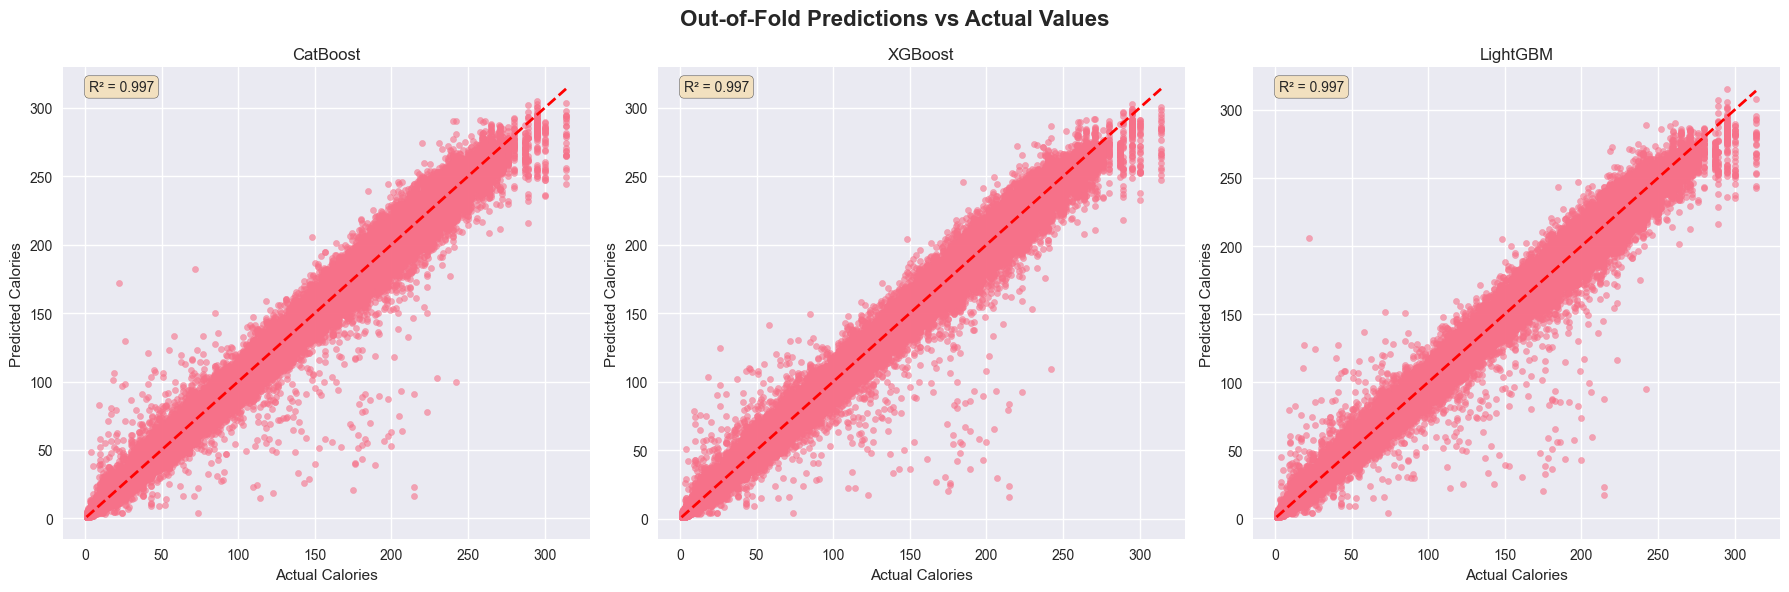

In [5]:
print("\n" + "="*50)
print("📊 MODEL EVALUATION")
print("="*50)

# Model performance comparison
model_performance = []
for name in models:
    mean_rmsle = np.mean(results[name]['rmsle'])
    std_rmsle = np.std(results[name]['rmsle'])
    mean_time = np.mean(results[name]['time'])
    model_performance.append({
        'Model': name,
        'Mean_RMSLE': mean_rmsle,
        'Std_RMSLE': std_rmsle,
        'Mean_Time': mean_time
    })
    print(f"{name} - Mean RMSLE: {mean_rmsle:.4f} ± {std_rmsle:.4f} | Avg Time: {mean_time:.1f}s")

# Visualisasi 6: Model Performance Comparison (DIPERBAIKI)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# RMSLE comparison dengan keterangan angka
model_names = list(models.keys())
mean_rmsles = [np.mean(results[name]['rmsle']) for name in model_names]
std_rmsles = [np.std(results[name]['rmsle']) for name in model_names]

bars1 = axes[0,0].bar(model_names, mean_rmsles, yerr=std_rmsles, capsize=5, alpha=0.7)
axes[0,0].set_title('Model RMSLE Comparison')
axes[0,0].set_ylabel('RMSLE')
axes[0,0].tick_params(axis='x', rotation=45)

# Tambahkan keterangan angka pada bar chart RMSLE
for i, (bar, rmsle, std) in enumerate(zip(bars1, mean_rmsles, std_rmsles)):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + std + 0.001,
                   f'{rmsle:.4f}±{std:.4f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

# Training time comparison dengan keterangan angka
mean_times = [np.mean(results[name]['time']) for name in model_names]
bars2 = axes[0,1].bar(model_names, mean_times, alpha=0.7, color='orange')
axes[0,1].set_title('Average Training Time per Fold')
axes[0,1].set_ylabel('Time (seconds)')
axes[0,1].tick_params(axis='x', rotation=45)

# Tambahkan keterangan angka pada bar chart training time
for bar, time in zip(bars2, mean_times):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + max(mean_times)*0.01,
                   f'{time:.1f}s',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

# RMSLE distribution across folds
rmsle_data = []
for name in model_names:
    for fold, rmsle in enumerate(results[name]['rmsle']):
        rmsle_data.append({'Model': name, 'Fold': fold+1, 'RMSLE': rmsle})

rmsle_df = pd.DataFrame(rmsle_data)
sns.boxplot(data=rmsle_df, x='Model', y='RMSLE', ax=axes[1,0])
axes[1,0].set_title('RMSLE Distribution Across Folds')
axes[1,0].tick_params(axis='x', rotation=45)

# Individual model fold performance
for name in model_names:
    axes[1,1].plot(range(1, FOLDS+1), results[name]['rmsle'], 
                   marker='o', label=name, linewidth=2, markersize=6)
axes[1,1].set_title('RMSLE per Fold')
axes[1,1].set_xlabel('Fold')
axes[1,1].set_ylabel('RMSLE')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualisasi 7: Out-of-Fold Predictions vs Actual
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Out-of-Fold Predictions vs Actual Values', fontsize=16, fontweight='bold')

y_true_original = np.expm1(y)

for i, name in enumerate(model_names):
    oof_pred_original = np.expm1(results[name]['oof'])
    
    axes[i].scatter(y_true_original, oof_pred_original, alpha=0.6, s=20)
    axes[i].plot([y_true_original.min(), y_true_original.max()], 
                 [y_true_original.min(), y_true_original.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Calories')
    axes[i].set_ylabel('Predicted Calories')
    axes[i].set_title(f'{name}')
    
    # Add R² score
    r2 = r2_score(y_true_original, oof_pred_original)
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes,
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()



# MODEL BLENDING


🔀 MODEL BLENDING

✅ Optimized Weights:
CatBoost = 0.3333
XGBoost = 0.3333
LightGBM = 0.3333

Blended Model RMSLE: 0.0593


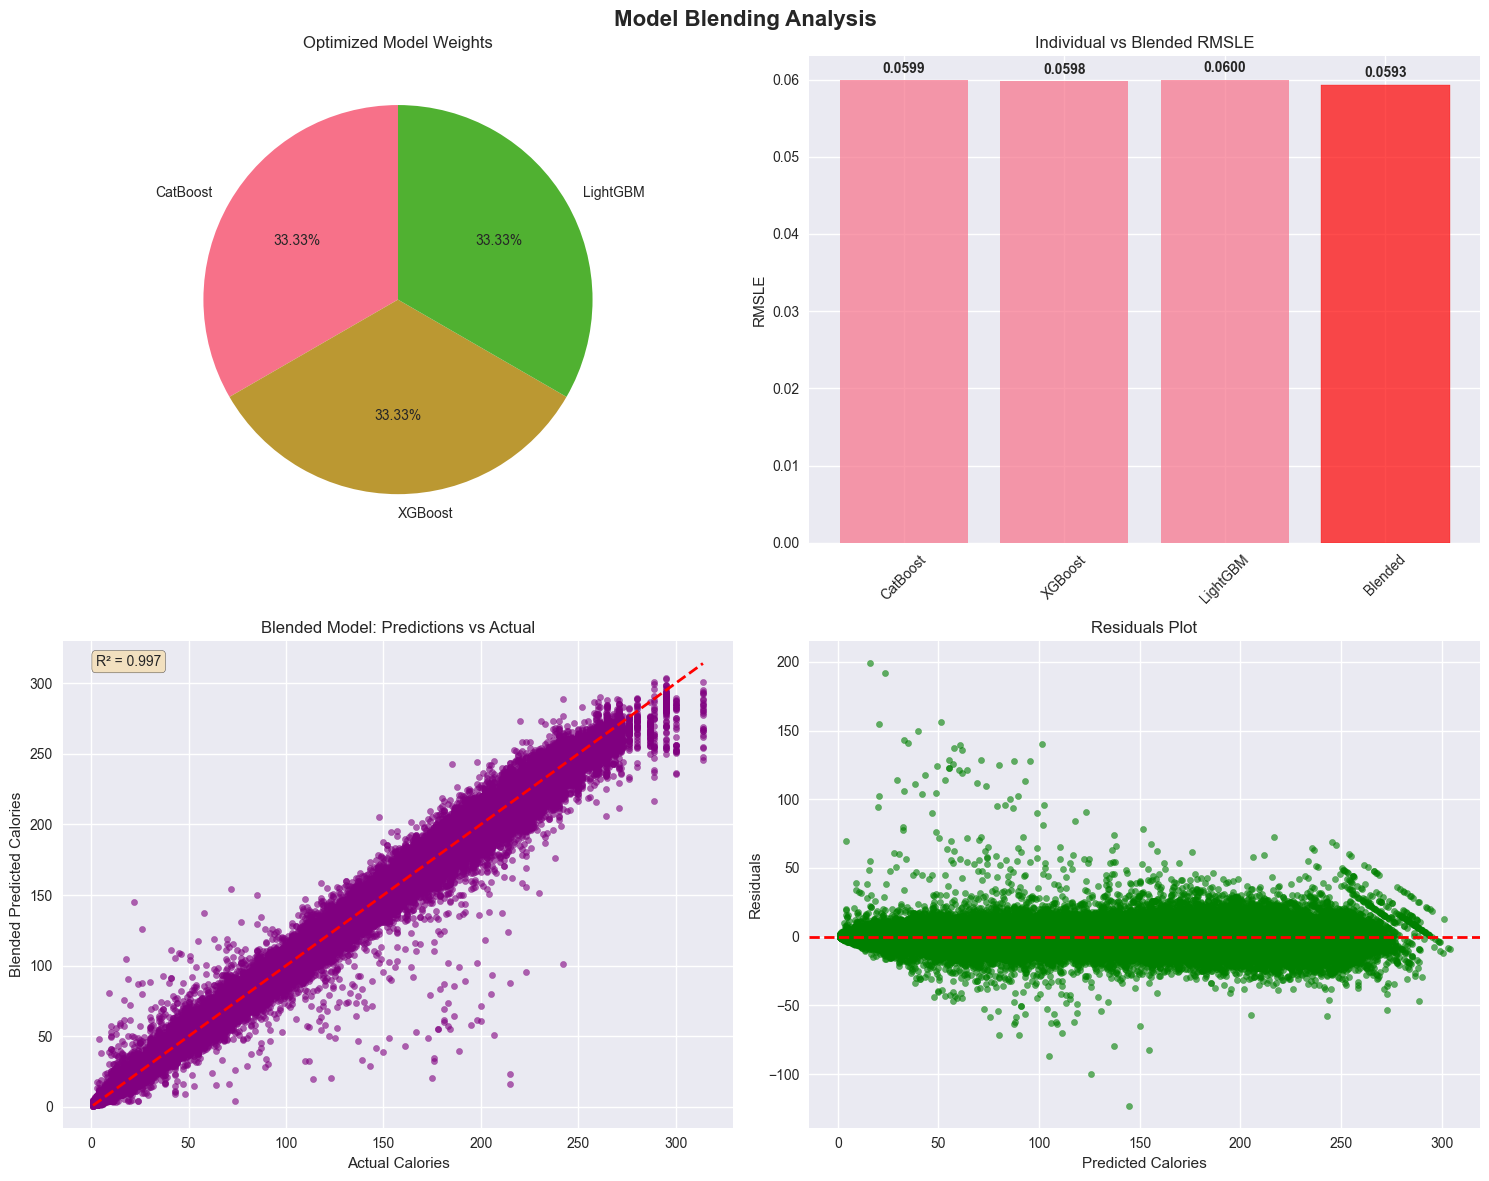

In [6]:
print("\n" + "="*50)
print("🔀 MODEL BLENDING")
print("="*50)

oof_preds = {name: np.expm1(results[name]['oof']) for name in results}
test_preds = {name: np.expm1(results[name]['pred']) for name in results}
y_true = np.expm1(y)

def rmsle_loss(weights):
    blended = (
        weights[0] * oof_preds['CatBoost'] +
        weights[1] * oof_preds['XGBoost'] +
        weights[2] * oof_preds['LightGBM']
    )
    return np.sqrt(mean_squared_log_error(y_true, blended))

initial_weights = [1/3, 1/3, 1/3]
constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})
bounds = [(0, 1)] * 3

res = minimize(rmsle_loss, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
best_weights = res.x

print(f"\n✅ Optimized Weights:")
for i, name in enumerate(model_names):
    print(f"{name} = {best_weights[i]:.4f}")

# Calculate blended predictions
blended_oof = (
    best_weights[0] * oof_preds['CatBoost'] +
    best_weights[1] * oof_preds['XGBoost'] +
    best_weights[2] * oof_preds['LightGBM']
)

blended_test = (
    best_weights[0] * test_preds['CatBoost'] +
    best_weights[1] * test_preds['XGBoost'] +
    best_weights[2] * test_preds['LightGBM']
)

blended_rmsle = np.sqrt(mean_squared_log_error(y_true, blended_oof))
print(f"\nBlended Model RMSLE: {blended_rmsle:.4f}")

# Visualisasi 8: Model Blending Results (DIPERBAIKI)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Blending Analysis', fontsize=16, fontweight='bold')

# Weights visualization
axes[0,0].pie(best_weights, labels=model_names, autopct='%1.2f%%', startangle=90)
axes[0,0].set_title('Optimized Model Weights')

# Individual vs Blended RMSLE dengan keterangan angka
individual_rmsles = [np.sqrt(mean_squared_log_error(y_true, oof_preds[name])) for name in model_names]
all_models = model_names + ['Blended']
all_rmsles = individual_rmsles + [blended_rmsle]

bars3 = axes[0,1].bar(all_models, all_rmsles, alpha=0.7)
bars3[-1].set_color('red')  # Highlight blended model
axes[0,1].set_title('Individual vs Blended RMSLE')
axes[0,1].set_ylabel('RMSLE')
axes[0,1].tick_params(axis='x', rotation=45)

# Tambahkan keterangan angka pada bar chart individual vs blended RMSLE
for bar, rmsle in zip(bars3, all_rmsles):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + max(all_rmsles)*0.01,
                   f'{rmsle:.4f}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

# Blended predictions vs actual
axes[1,0].scatter(y_true, blended_oof, alpha=0.6, s=20, color='purple')
axes[1,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Calories')
axes[1,0].set_ylabel('Blended Predicted Calories')
axes[1,0].set_title('Blended Model: Predictions vs Actual')

# Add R² score for blended model
r2_blended = r2_score(y_true, blended_oof)
axes[1,0].text(0.05, 0.95, f'R² = {r2_blended:.3f}', transform=axes[1,0].transAxes,
               bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

# Residuals plot
residuals = y_true - blended_oof
axes[1,1].scatter(blended_oof, residuals, alpha=0.6, s=20, color='green')
axes[1,1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1,1].set_xlabel('Predicted Calories')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals Plot')

plt.tight_layout()
plt.show()

# FINAL PREDICTIONS & SUBMISSION


📋 FINAL PREDICTIONS
Submission created successfully!

Submission Head:
       id    Calories
0  750000   27.369073
1  750001  107.896001
2  750002   87.392661
3  750003  125.488407
4  750004   75.836905
5  750005   21.624053
6  750006   48.354789
7  750007    6.777132
8  750008   10.035503
9  750009  203.650636

Prediction Statistics:
Mean: 88.17
Median: 76.43
Min: 1.00
Max: 299.09
Std: 62.26

🔄 Menghitung Weighted Ensemble Feature Importance...
📊 Bobot Model dalam Ensemble:
  CatBoost   | Weight: 0.333 | RMSLE: 0.0599
  XGBoost    | Weight: 0.334 | RMSLE: 0.0598
  LightGBM   | Weight: 0.333 | RMSLE: 0.0600
📊 Mengambil feature importance dari CatBoost...
✅ Berhasil mendapatkan 117 feature importances dari CatBoost
📊 Mengambil feature importance dari XGBoost...
✅ Berhasil mendapatkan 117 feature importances dari XGBoost
📊 Mengambil feature importance dari LightGBM...
✅ Berhasil mendapatkan 117 feature importances dari LightGBM

🔄 Menggabungkan feature importance dari 3 model...


<Figure size 1200x800 with 0 Axes>

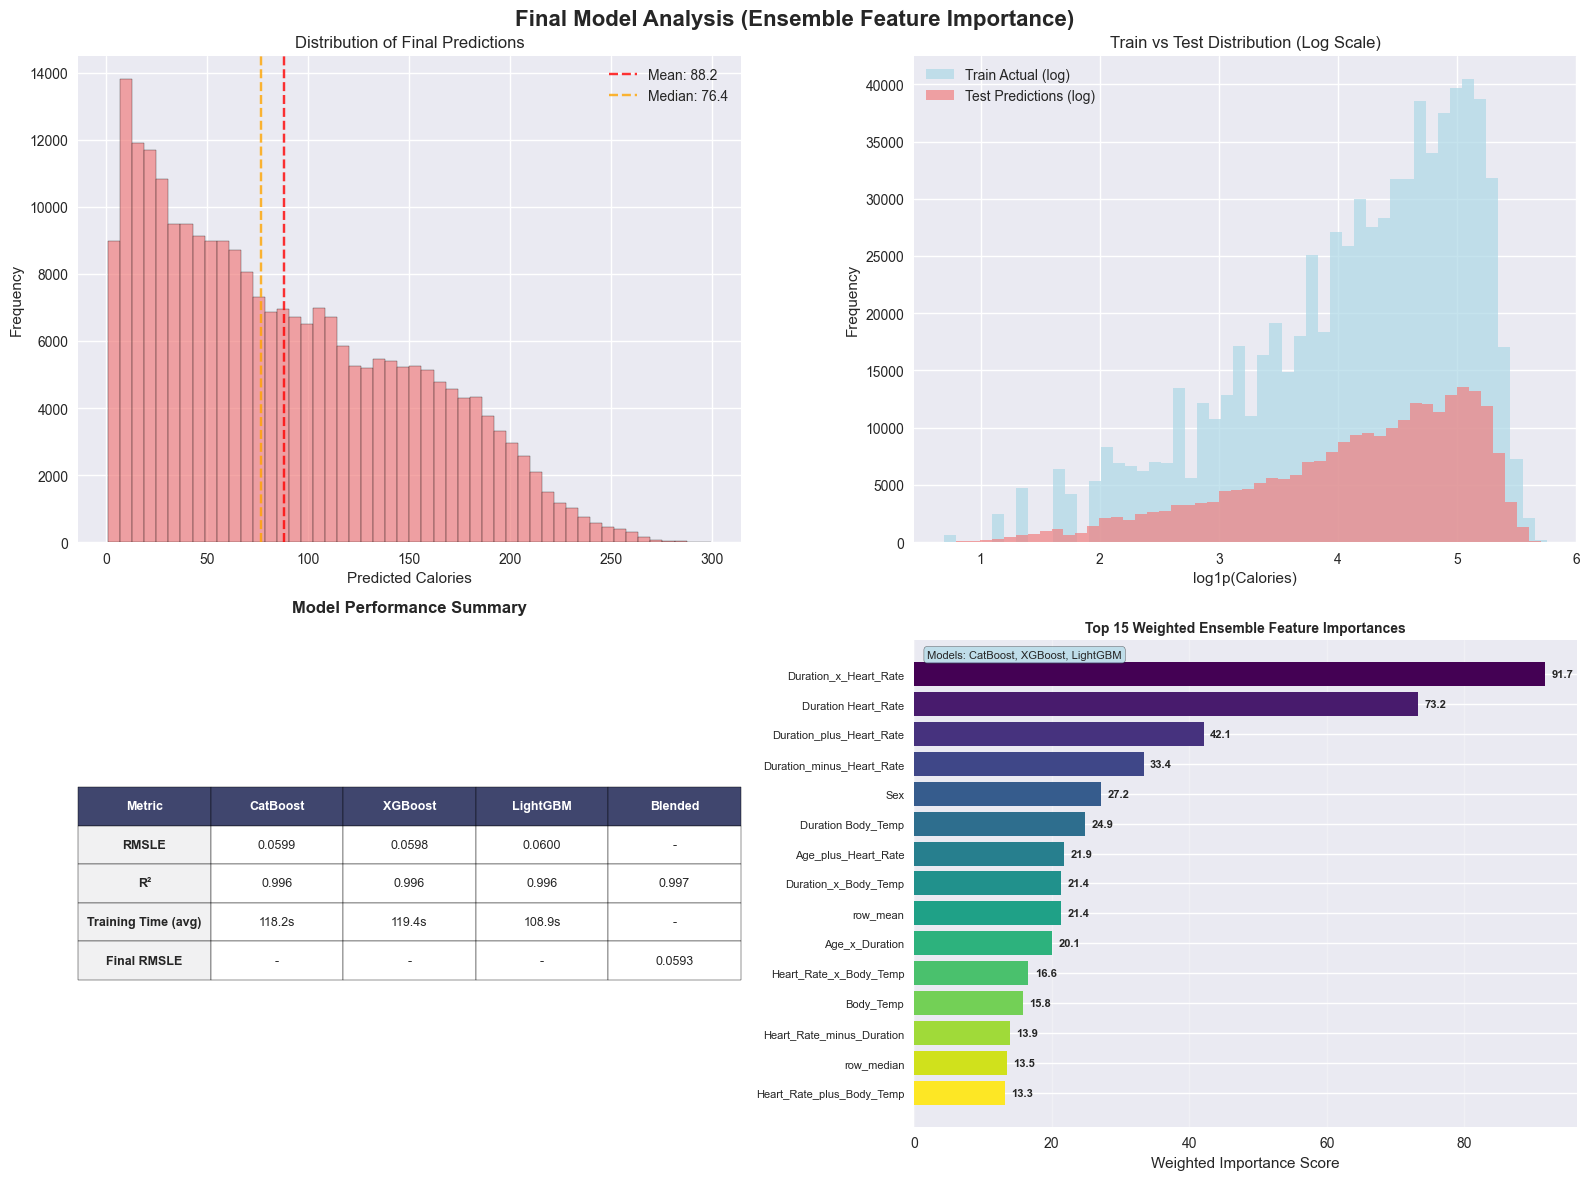


📊 Top 15 Weighted Ensemble Feature Importances:
Rank | Feature                             | Weighted Score | Normalized
   1 | Duration_x_Heart_Rate               |         91.74 |     100.0%
   2 | Duration Heart_Rate                 |         73.21 |      79.8%
   3 | Duration_plus_Heart_Rate            |         42.11 |      45.9%
   4 | Duration_minus_Heart_Rate           |         33.38 |      36.4%
   5 | Sex                                 |         27.23 |      29.7%
   6 | Duration Body_Temp                  |         24.90 |      27.1%
   7 | Age_plus_Heart_Rate                 |         21.86 |      23.8%
   8 | Duration_x_Body_Temp                |         21.44 |      23.4%
   9 | row_mean                            |         21.38 |      23.3%
  10 | Age_x_Duration                      |         20.09 |      21.9%
  11 | Heart_Rate_x_Body_Temp              |         16.64 |      18.1%
  12 | Body_Temp                           |         15.82 |      17.2%
  13 | Heart_R

In [7]:
print("\n" + "="*50)
print("📋 FINAL PREDICTIONS")
print("="*50)

# Clip predictions to reasonable range
blended_test_clipped = np.clip(blended_test, 1, 314)

# Create submission
submission['Calories'] = blended_test_clipped
submission.to_csv('D:\Perkuliahan\Data Science and Machine Learning\File Dataset\Predict Calorie Expenditure\submission.csv', index=False)

print("Submission created successfully!")
print("\nSubmission Head:")
print(submission.head(10))

print(f"\nPrediction Statistics:")
print(f"Mean: {blended_test_clipped.mean():.2f}")
print(f"Median: {np.median(blended_test_clipped):.2f}")
print(f"Min: {blended_test_clipped.min():.2f}")
print(f"Max: {blended_test_clipped.max():.2f}")
print(f"Std: {blended_test_clipped.std():.2f}")

# Fungsi untuk mendapatkan feature importance dari model yang sudah trained
def get_trained_model_importance(model_name, trained_model, feature_names):
    """
    Mendapatkan feature importance dari model yang sudah trained
    """
    try:
        print(f"📊 Mengambil feature importance dari {model_name}...")
        
        # Dapatkan feature importance berdasarkan tipe model
        if model_name == 'CatBoost':
            importance = trained_model.get_feature_importance()
        elif model_name in ['XGBoost', 'LightGBM']:
            importance = trained_model.feature_importances_
        else:
            print(f"⚠️  Model {model_name} tidak didukung untuk feature importance")
            return None
        
        # Pastikan panjang importance sesuai dengan feature names
        if len(importance) != len(feature_names):
            print(f"⚠️  Panjang importance ({len(importance)}) tidak sesuai dengan feature names ({len(feature_names)})")
            # Ambil sesuai panjang yang lebih pendek
            min_len = min(len(importance), len(feature_names))
            importance = importance[:min_len]
            feature_names = feature_names[:min_len]
        
        # Buat dictionary feature importance
        importance_dict = dict(zip(feature_names, importance))
        
        print(f"✅ Berhasil mendapatkan {len(importance_dict)} feature importances dari {model_name}")
        return importance_dict
        
    except Exception as e:
        print(f"❌ Error dalam mendapatkan feature importance untuk {model_name}: {str(e)}")
        return None

# Fungsi untuk melatih model sederhana hanya untuk feature importance
def train_simple_model_for_importance(model_name, X_data, y_data):
    """
    Melatih model sederhana hanya untuk mendapatkan feature importance
    """
    try:
        print(f"🔄 Training model sederhana untuk {model_name}...")
        
        # Bersihkan data dari kolom duplikat
        X_clean = X_data.loc[:, ~X_data.columns.duplicated()]
        
        # Inisialisasi model dengan parameter sederhana
        if model_name == 'CatBoost':
            simple_model = CatBoostRegressor(
                verbose=False, 
                random_seed=42, 
                cat_features=['Sex'],
                iterations=100,  # Sangat sedikit untuk cepat
                early_stopping_rounds=20
            )
        elif model_name == 'XGBoost':
            simple_model = XGBRegressor(
                n_estimators=100,  # Sangat sedikit untuk cepat
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                verbosity=0
            )
        elif model_name == 'LightGBM':
            simple_model = LGBMRegressor(
                n_estimators=100,  # Sangat sedikit untuk cepat
                max_depth=6,
                learning_rate=0.1,
                random_state=42, 
                verbose=-1
            )
        else:
            return None
        
        # Train model
        simple_model.fit(X_clean, y_data)
        return simple_model
        
    except Exception as e:
        print(f"❌ Error dalam training model sederhana untuk {model_name}: {str(e)}")
        return None

# Fungsi untuk menghitung weighted average feature importance
def get_weighted_ensemble_feature_importance(model_names, trained_models, X_data, y_data, results_dict, top_n=15):
    """
    Menghitung weighted average feature importance dari semua model ensemble
    """
    print("\n🔄 Menghitung Weighted Ensemble Feature Importance...")
    
    # Hitung bobot berdasarkan inverse RMSLE (model terbaik dapat bobot lebih tinggi)
    model_weights = {}
    total_inverse_rmsle = 0
    
    for model_name in model_names:
        avg_rmsle = np.mean(results_dict[model_name]['rmsle'])
        # Gunakan inverse RMSLE sebagai bobot (semakin kecil RMSLE, semakin besar bobot)
        inverse_rmsle = 1 / (avg_rmsle + 1e-8)  # Tambah epsilon untuk menghindari division by zero
        model_weights[model_name] = inverse_rmsle
        total_inverse_rmsle += inverse_rmsle
    
    # Normalisasi bobot agar total = 1
    for model_name in model_weights:
        model_weights[model_name] = model_weights[model_name] / total_inverse_rmsle
    
    print("📊 Bobot Model dalam Ensemble:")
    for model_name, weight in model_weights.items():
        avg_rmsle = np.mean(results_dict[model_name]['rmsle'])
        print(f"  {model_name:10} | Weight: {weight:.3f} | RMSLE: {avg_rmsle:.4f}")
    
    # Siapkan data untuk feature importance
    X_clean = X_data.loc[:, ~X_data.columns.duplicated()]
    feature_names = X_clean.columns.tolist()
    
    # Dapatkan feature importance dari setiap model
    all_importances = {}
    successful_models = []
    
    for model_name in model_names:
        importance_dict = None
        
        # Coba ambil dari model yang sudah trained (jika ada)
        if model_name in trained_models and trained_models[model_name] is not None:
            importance_dict = get_trained_model_importance(model_name, trained_models[model_name], feature_names)
        
        # Jika gagal, coba training model sederhana
        if importance_dict is None:
            print(f"🔄 Model {model_name} tidak tersedia, training model sederhana...")
            simple_model = train_simple_model_for_importance(model_name, X_clean, y_data)
            if simple_model is not None:
                importance_dict = get_trained_model_importance(model_name, simple_model, feature_names)
        
        if importance_dict is not None:
            all_importances[model_name] = importance_dict
            successful_models.append(model_name)
        else:
            print(f"⚠️  Gagal mendapatkan feature importance untuk {model_name}")
    
    if not successful_models:
        print("❌ Tidak ada model yang berhasil memberikan feature importance")
        return None, None
    
    # Hitung weighted average feature importance
    print(f"\n🔄 Menggabungkan feature importance dari {len(successful_models)} model...")
    
    # Ambil semua feature names dari model yang berhasil
    all_features = set()
    for model_name in successful_models:
        all_features.update(all_importances[model_name].keys())
    
    weighted_importance = {}
    
    for feature in all_features:
        weighted_score = 0
        total_weight = 0
        
        for model_name in successful_models:
            if feature in all_importances[model_name]:
                # Normalisasi importance per model (0-100 scale)
                model_importances = list(all_importances[model_name].values())
                max_importance = max(model_importances) if max(model_importances) > 0 else 1
                normalized_importance = (all_importances[model_name][feature] / max_importance) * 100
                
                # Tambahkan ke weighted score
                weighted_score += normalized_importance * model_weights[model_name]
                total_weight += model_weights[model_name]
        
        # Hitung rata-rata tertimbang
        if total_weight > 0:
            weighted_importance[feature] = weighted_score / total_weight
        else:
            weighted_importance[feature] = 0
    
    # Sort berdasarkan importance dan ambil top N
    sorted_features = sorted(weighted_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Buat DataFrame
    ensemble_importance_df = pd.DataFrame(sorted_features, columns=['feature', 'importance'])
    
    return ensemble_importance_df, successful_models

# Visualisasi 9: Final Predictions Distribution (DIPERBAIKI dengan Ensemble Feature Importance)
plt.figure(figsize=(12, 8))

# Create subplots for final analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Final Model Analysis (Ensemble Feature Importance)', fontsize=16, fontweight='bold')

# Prediction distribution
axes[0,0].hist(blended_test_clipped, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,0].set_title('Distribution of Final Predictions')
axes[0,0].set_xlabel('Predicted Calories')
axes[0,0].set_ylabel('Frequency')

# Tambahkan statistik pada histogram
mean_pred = blended_test_clipped.mean()
median_pred = np.median(blended_test_clipped)
axes[0,0].axvline(mean_pred, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_pred:.1f}')
axes[0,0].axvline(median_pred, color='orange', linestyle='--', alpha=0.8, label=f'Median: {median_pred:.1f}')
axes[0,0].legend()

# Training vs Test predictions comparison
axes[0,1].hist(y, bins=50, alpha=0.7, label='Train Actual (log)', color='lightblue')
axes[0,1].hist(np.log1p(blended_test_clipped), bins=50, alpha=0.7, label='Test Predictions (log)', color='lightcoral')
axes[0,1].set_title('Train vs Test Distribution (Log Scale)')
axes[0,1].set_xlabel('log1p(Calories)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Model performance summary
performance_data = {
    'Metric': ['RMSLE', 'R²', 'Training Time (avg)', 'Final RMSLE'],
    'CatBoost': [f"{np.mean(results['CatBoost']['rmsle']):.4f}", 
                 f"{r2_score(y, results['CatBoost']['oof']):.3f}",
                 f"{np.mean(results['CatBoost']['time']):.1f}s", '-'],
    'XGBoost': [f"{np.mean(results['XGBoost']['rmsle']):.4f}", 
                f"{r2_score(y, results['XGBoost']['oof']):.3f}",
                f"{np.mean(results['XGBoost']['time']):.1f}s", '-'],
    'LightGBM': [f"{np.mean(results['LightGBM']['rmsle']):.4f}", 
                 f"{r2_score(y, results['LightGBM']['oof']):.3f}",
                 f"{np.mean(results['LightGBM']['time']):.1f}s", '-'],
    'Blended': ['-', f"{r2_blended:.3f}", '-', f"{blended_rmsle:.4f}"]
}

# Create table yang lebih rapi
axes[1,0].axis('tight')
axes[1,0].axis('off')

# Transpose data untuk membuat table yang benar
table_data = []
for metric in performance_data['Metric']:
    row = [metric]
    for model in ['CatBoost', 'XGBoost', 'LightGBM', 'Blended']:
        row.append(performance_data[model][performance_data['Metric'].index(metric)])
    table_data.append(row)

table = axes[1,0].table(cellText=table_data,
                        colLabels=['Metric', 'CatBoost', 'XGBoost', 'LightGBM', 'Blended'],
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Styling table
for i in range(len(table_data) + 1):  # +1 for header
    for j in range(5):  # 5 columns
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#40466e')
            cell.set_text_props(weight='bold', color='white')
        elif j == 0:  # First column (metrics)
            cell.set_facecolor('#f1f1f2')
            cell.set_text_props(weight='bold')
        else:
            cell.set_facecolor('white')

axes[1,0].set_title('Model Performance Summary', fontsize=12, fontweight='bold', pad=20)

# Weighted Ensemble Feature Importance
# Coba ambil model yang sudah trained (model terakhir dari setiap fold)
model_names = list(models.keys())
trained_models = models  # Ini adalah model dari fold terakhir

ensemble_importance_df, successful_models = get_weighted_ensemble_feature_importance(
    model_names, trained_models, X, y, results, top_n=15
)

if ensemble_importance_df is not None and len(ensemble_importance_df) > 0:
    # Plot ensemble feature importance
    colors = plt.cm.viridis(np.linspace(0, 1, len(ensemble_importance_df)))
    bars = axes[1,1].barh(range(len(ensemble_importance_df)), 
                         ensemble_importance_df['importance'], 
                         color=colors)
    
    axes[1,1].set_yticks(range(len(ensemble_importance_df)))
    axes[1,1].set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                              for name in ensemble_importance_df['feature']], 
                             fontsize=8)
    axes[1,1].set_xlabel('Weighted Importance Score')
    axes[1,1].set_title(f'Top 15 Weighted Ensemble Feature Importances', fontsize=10, fontweight='bold')
    axes[1,1].invert_yaxis()
    
    # Tambahkan nilai importance di ujung bar
    for i, (bar, importance_val) in enumerate(zip(bars, ensemble_importance_df['importance'])):
        width = bar.get_width()
        axes[1,1].text(width + max(ensemble_importance_df['importance'])*0.01, 
                      bar.get_y() + bar.get_height()/2,
                      f'{importance_val:.1f}',
                      ha='left', va='center', fontsize=8, fontweight='bold')
    
    # Tambahkan grid untuk kemudahan membaca
    axes[1,1].grid(axis='x', alpha=0.3)
    
    # Tambahkan keterangan model yang digunakan
    model_text = f"Models: {', '.join(successful_models)}"
    axes[1,1].text(0.02, 0.98, model_text, transform=axes[1,1].transAxes,
                   fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
    
else:
    # Jika gagal, tampilkan pesan error
    axes[1,1].text(0.5, 0.5, 'Weighted Ensemble\nFeature Importance\nTidak Dapat Ditampilkan\n\nPeriksa data dan model', 
                   ha='center', va='center', transform=axes[1,1].transAxes,
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='lightcoral', alpha=0.8),
                   fontsize=10)
    axes[1,1].set_title('Weighted Ensemble Feature Importance', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Tampilkan feature importance dalam bentuk text
if ensemble_importance_df is not None and len(ensemble_importance_df) > 0:
    print(f"\n📊 Top 15 Weighted Ensemble Feature Importances:")
    print("="*70)
    print(f"{'Rank':4} | {'Feature':35} | {'Weighted Score':13} | {'Normalized':10}")
    print("="*70)
    for idx, (_, row) in enumerate(ensemble_importance_df.iterrows(), 1):
        normalized = (row['importance'] / ensemble_importance_df['importance'].max()) * 100
        print(f"{idx:4} | {row['feature'][:35]:35} | {row['importance']:13.2f} | {normalized:9.1f}%")
    print("="*70)
    
    print(f"\n🤖 Models yang berhasil digunakan: {', '.join(successful_models)}")

print("\n" + "="*50)
print("✅ ANALISIS SELESAI!")
print("="*50)
print("📊 Summary:")
print(f"• Dataset: {train.shape[0]} training samples, {test.shape[0]} test samples")
print(f"• Features: {len(FEATURES)} total features after engineering")
print(f"• Models: {len(models)} models trained with {FOLDS}-fold CV")
print(f"• Best Individual Model: {min(model_names, key=lambda x: np.mean(results[x]['rmsle']))}")
print(f"• Blended Model RMSLE: {blended_rmsle:.4f}")
print(f"• Final Predictions Range: {blended_test_clipped.min():.1f} - {blended_test_clipped.max():.1f} calories")
print(f"• Feature Importance: Weighted Average dari {len(successful_models) if 'successful_models' in locals() else 'N/A'} model")

# Tambahan: Analisis distribusi prediksi
print(f"\n📈 Prediction Distribution Analysis:")
print(f"• Predictions dalam range 1-100 calories: {np.sum((blended_test_clipped >= 1) & (blended_test_clipped <= 100))} samples")
print(f"• Predictions dalam range 100-200 calories: {np.sum((blended_test_clipped > 100) & (blended_test_clipped <= 200))} samples")
print(f"• Predictions dalam range 200-314 calories: {np.sum((blended_test_clipped > 200) & (blended_test_clipped <= 314))} samples")